In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gym
import gym_connect4

import tqdm
import random

In [6]:
# Create env
env = gym.make('Connect4Env-v0')

In [2]:
# This agent allow an human to play

class HumanAgent():

    def __init__(self):
        self.input = -1

    def step_kaggle(self, obv):
        self.input = int(input('Your action:'))
        return self.input

In [131]:
# An agent that respect the markov decision process:
# The agent will have rules pre-implemented

# epsilon is the exploration rate
# alpha is the learning rate
# gamma is the discount rate

class Agent():

    def __init__(self, nb_action, epsilon, epsilon_decay_factor, min_epsilon, alpha, gamma):
        self.epsilon = epsilon
        self.epsilon_decay_factor = epsilon_decay_factor
        self.min_epsilon = min_epsilon
        self.alpha = alpha
        self.gamma = gamma

        self.nb_action = nb_action

        self.q_table = {}
        self.memory = []
      
        self.action = -1
        self.obv_hashed = None

        # Lists used to keep track of the training progression
        self.nb_game = 0
        self.learning_stats = {
            '1': [0],
            '0': [0],
            '-1': [0],
            'explored_states': [0],
            'epsilon': []
        }

    def __hash__(self, obv):
        return ''.join(str(x) for x in obv)

    def __argmax__(self, action_probs):
        max_q_value = max(action_probs)
        actions = [index for index, q_value in enumerate(action_probs) if q_value == max_q_value]
        return random.choice(actions)

    def save(self, file):
        # Save the Q_table dictionary in the given file
        np.save(file, self.q_table)

    def load(self, file):
        # Load the given file as an already trained Q_table
        self.q_table = np.load(file, allow_pickle=True).item()

    def step(self, obv):
        self.obv_hashed = self.__hash__(obv['board'])

        action_probs = self.q_table.get(self.obv_hashed)

        if action_probs is None:
            self.q_table[self.obv_hashed] = obv['action_mask'][:-1].astype(int) - 1
            action_probs = self.q_table[self.obv_hashed]

        if random.uniform(0, 1) < self.epsilon:
            actions = [index for index, action in enumerate(obv['action_mask'][:-1]) if action == 1]
            self.action = random.choice(actions)

        else:
            self.action = self.__argmax__(action_probs)
            
        return self.action
        
    def push_memory(self, reward):
        self.memory.append((self.obv_hashed, self.action, reward))
    
    def flush_memory(self):
        self.memory = []
        
    def __push_learning_stats__(self, reward):
        self.nb_game += 1

        for k in ['1', '0', '-1']:
            r = self.learning_stats[k][-1] + (1 / self.nb_game) * ((k == str(int(reward))) - self.learning_stats[k][-1])
            self.learning_stats[k].append(r)
        
        self.learning_stats['explored_states'].append(len(self.q_table))
        self.learning_stats['epsilon'].append(self.epsilon)

    def update_learning_stats(self):
        # Updates tracking values
        self.__push_learning_stats__(self.memory[-1][2])

    def learn(self):
        if len(self.memory) == 0:
            # Updates the epsilon to reduce the amount of random actions
            self.epsilon *= self.epsilon_decay_factor
            self.epsilon = max(self.epsilon, self.min_epsilon)

            return 0

        else:
            (obv_hashed, action, reward) = self.memory.pop(0)
            q_reward = reward + self.gamma * self.learn()

            self.q_table[obv_hashed][action] = self.q_table[obv_hashed][action] + self.alpha * (q_reward - self.q_table[obv_hashed][action])

            return q_reward

    def step_kaggle(self, obv):
        # Steps through a turn in a real game (no random choices)
        self.obv_hashed = self.__hash__(obv['board'])

        action_probs = self.q_table.get(self.obv_hashed)

        if action_probs is None:
            self.q_table[self.obv_hashed] = obv['action_mask'][:-1].astype(int) - 1
            action_probs = self.q_table[self.obv_hashed]

        self.action = self.__argmax__(action_probs)
            
        return self.action

    def run(self):
        # Plays a game
        return lambda obv, conf: self.__step_kaggle__(obv.board, conf)

    def display_explored_states(self):
        plt.plot(self.learning_stats['explored_states'])
        plt.xlabel('Episode')
        plt.ylabel('Explored states')
        plt.show()
    
    def display_epsilon(self):
        plt.plot(self.learning_stats['epsilon'])
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

In [133]:
nb_game_action = 7

alpha = 0.1
gamma = 0.6

epsilon = 0.99999
min_epsilon = 0.1
epsilon_decay_factor = 0.9999

num_episodes = 1000

# alpha_decay_step = 1000
# alpha_decay_rate = 0.9

In [134]:
# Create the two agents
agents = [
    Agent(nb_game_action, epsilon, epsilon_decay_factor, min_epsilon, alpha, gamma),
    Agent(nb_game_action, epsilon, epsilon_decay_factor, min_epsilon, alpha, gamma)
]

# agents[0].load("q_table_1.npy")
# agents[1].load("q_table_2.npy")

In [135]:
actions = {0: 0, 1: 0}

for epoch in tqdm.tqdm(range(num_episodes)):
    # Reset the env and get the first board status
    obv = env.reset()
    done = False

    # Switch the playing agent
    agent_nb = epoch % 2 
    turn = 0

    while not done:
        actions[turn] = agents[agent_nb].step(obv[turn])
        obv, reward, done, info = env.step(actions)

        agents[agent_nb].push_memory(reward[turn])

        turn = (turn + 1) % 2
        agent_nb = (agent_nb + 1) % 2

    agents[agent_nb].push_memory(reward[turn])

    for a in agents:
        a.update_learning_stats()
        a.learn()
        a.flush_memory()

100%|██████████| 1000/1000 [00:10<00:00, 95.06it/s]


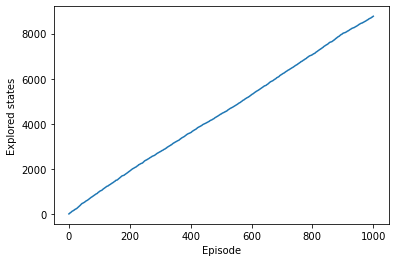

In [136]:
agents[0].display_explored_states()

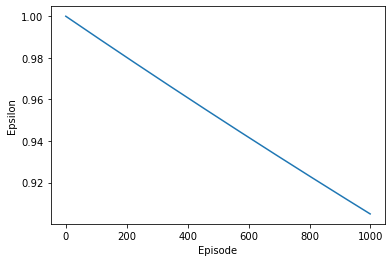

In [137]:
agents[0].display_epsilon()

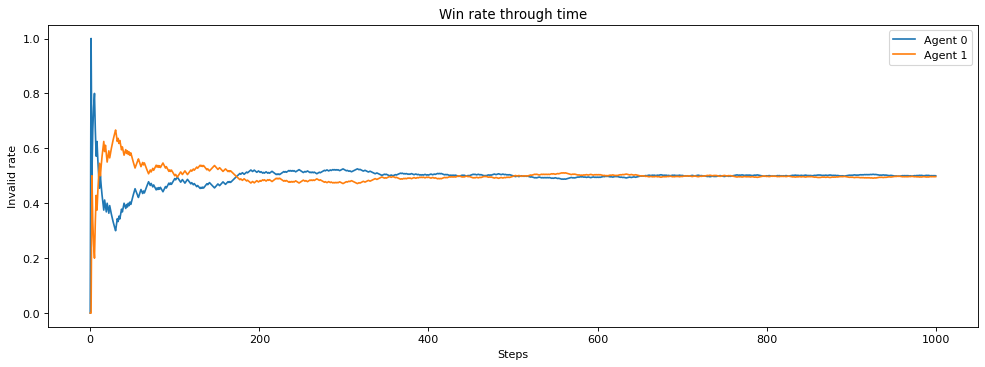

In [138]:
# Print results
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
legends = []

for i, a in enumerate(agents):
    plt.plot(a.learning_stats['1'])
    legends.append("Agent %d" % i)

# Legends and Title:
plt.title("Win rate through time")
plt.legend(legends)
plt.xlabel("Steps")
plt.ylabel("Invalid rate")

# Plot
plt.show()

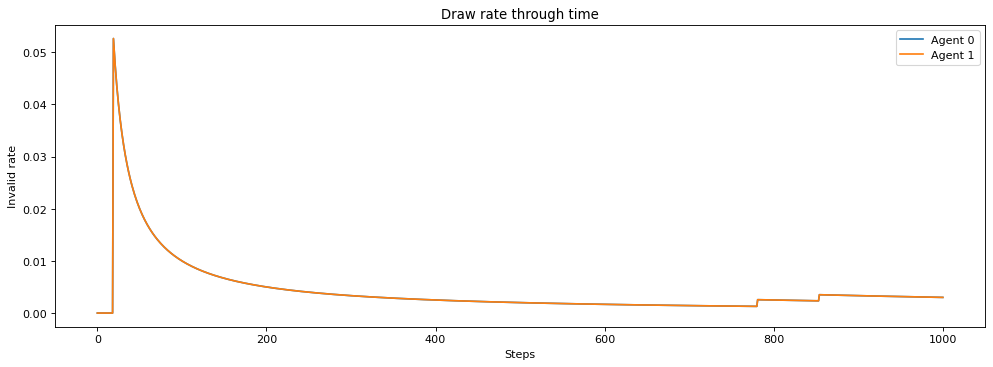

In [139]:
# Print results
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
legends = []

for i, a in enumerate(agents):
    plt.plot(a.learning_stats['0'])
    legends.append("Agent %d" % i)

# Legends and Title:
plt.title("Draw rate through time")
plt.legend(legends)
plt.xlabel("Steps")
plt.ylabel("Invalid rate")

# Plot
plt.show()

In [24]:
agents[0].save("q_table_1.npy")
agents[1].save("q_table_2.npy")

In [1]:
# PLay against your agent:
players_agent = [agents[0], HumanAgent()]

# The agent will act with its own knowledge, there no exploration:
obv = env.reset()
turn = 0

done = False
actions = {0: 0, 1: 0}

env.render()

while not done:
    actions[turn] = players_agent[turn].step_kaggle(obv[turn])
    obv, reward, done, info = env.step(actions)

    turn = (turn + 1) % 2

    env.render()
    print('')

NameError: name 'agents' is not defined

In [96]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agents[0].run(), "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agents[0].run(), "negamax"], num_episodes=10)))

NameError: name 'evaluate' is not defined

In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(agent_run, "submission.py")

In [ ]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")